# Antisymmetric nODE with perturbation

the goal of this code is to train a nODE with right hand side 
     $$\tanh( \hat W x + b)$$
with 
    $$\hat W = W - W^T + \epsilon P + \gamma I,   $$ 
where the norm of P is small

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
# seed = 56
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

18



# Data preparation

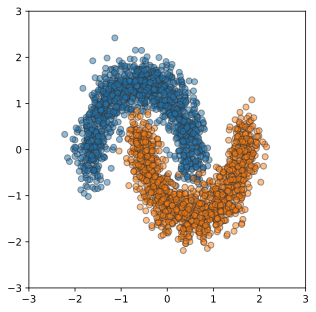

In [2]:
data_noise = 0.15
plotlim = [-3, 3]
subfolder = 'traj_moons'


from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('moons', noise = data_noise, plotlim = plotlim, random_state = seed)

## Training and generating level sets

In [3]:
from models.neural_odes import convolutionalNeuralODE

hidden_dim = 10
data_dim = 2 
augment_dim = 0

num_epochs = 80 #number of optimization runs in which the dataset is used for gradient decent
eps = 0.2
output_dim = 2

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 1, 1
bound = 0.
fp = False 
cross_entropy = True
turnpike = False

non_linearity = 'tanh' #'relu' #
architecture =  'outside' # 'inside' # 

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
cnode = convolutionalNeuralODE(device, data_dim, hidden_dim, output_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps)

optimizer_cnode = torch.optim.Adam(cnode.parameters(), lr=1e-3) 

In [4]:
from models.training import convolutionalTrainer

antisymm_diag = .03
trainer_cnode = convolutionalTrainer(cnode, optimizer_cnode, device, cross_entropy=cross_entropy,
                        verbose = True, antisymm_diag = antisymm_diag)
trainer_cnode.train(dataloader, num_epochs)


Epoch 0/38
Loss: 0.710
Increased loss for antisymmetry:  3.598

Epoch 10/38
Loss: 0.703
Increased loss for antisymmetry:  3.404

Epoch 20/38
Loss: 0.577
Increased loss for antisymmetry:  3.214

Epoch 30/38
Loss: 0.565
Increased loss for antisymmetry:  3.027
Epoch 1: 0.611

Epoch 0/38
Loss: 0.571
Increased loss for antisymmetry:  2.880

Epoch 10/38
Loss: 0.518
Increased loss for antisymmetry:  2.700

Epoch 20/38
Loss: 0.452
Increased loss for antisymmetry:  2.523

Epoch 30/38
Loss: 0.479
Increased loss for antisymmetry:  2.351
Epoch 2: 0.483

Epoch 0/38
Loss: 0.369
Increased loss for antisymmetry:  2.215

Epoch 10/38
Loss: 0.421
Increased loss for antisymmetry:  2.050

Epoch 20/38
Loss: 0.423
Increased loss for antisymmetry:  1.889

Epoch 30/38
Loss: 0.342
Increased loss for antisymmetry:  1.733
Epoch 3: 0.404

Epoch 0/38
Loss: 0.374
Increased loss for antisymmetry:  1.611

Epoch 10/38
Loss: 0.330
Increased loss for antisymmetry:  1.463

Epoch 20/38
Loss: 0.370
Increased loss for antis

/Users/queirolo/.local/share/virtualenvs/TUM_nODE-bBJE3WN-/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


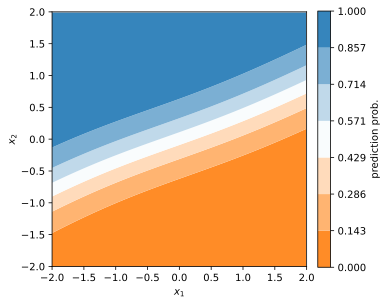

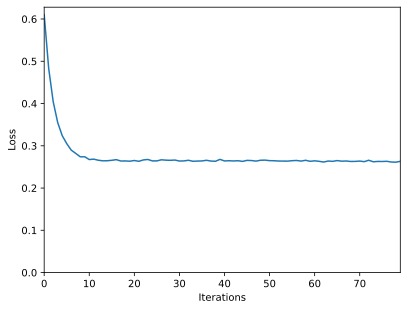

In [5]:
from plots.plots import classification_levelsets
classification_levelsets(cnode)
plt.plot(trainer_cnode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_cnode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [6]:
from scipy.io import savemat

W = cnode.flow.dynamics.fc2_time[0].weight.detach().numpy()
b = cnode.flow.dynamics.fc2_time[0].bias.detach().numpy()

#print(W,b)
dic = {"W": W, "b": b, "gamma": antisymm_diag}
savemat("coefs_convolutionalNode.mat", dic)

In [14]:
added_loss = 0
for W in trainer_cnode.model.parameters():
    if len(list(W.size())) == 2 and list(W.size())[0] == list(W.size())[1]:
        added_loss += torch.norm(W + W.T) + torch.linalg.vector_norm(W.diag() - trainer_cnode.antisymm_diag)
        print(torch.linalg.vector_norm(W.diag() - trainer_cnode.antisymm_diag))

tensor(0.0946, grad_fn=<LinalgVectorNormBackward0>)


In [11]:
added_loss.item()

0.09553784132003784

In [12]:
torch.linalg.vector_norm(W.diag() - trainer_cnode.antisymm_diag)

tensor(0.1678, grad_fn=<LinalgVectorNormBackward0>)

In [13]:
torch.norm(W + W.T)

/var/folders/nq/lv0cxwc9499c381g1gblftdm0000gn/T/ipykernel_1941/2203510987.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3575.)
  torch.norm(W + W.T)


tensor(0.3903, grad_fn=<LinalgVectorNormBackward0>)